In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import warnings

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("WARNING: 'prophet' library not found. The Prophet section will be skipped.")
    print("Install it via: pip install prophet")

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# --- 1. DATA LOADING & CLEANING ---

df = pd.read_csv('data/hanoi_air_weather_final.csv')

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

# Set time as index for easier plotting and manipulation
df.set_index('time', inplace=True)

# Filter for data where we actually have PM2.5
df_model = df.dropna(subset=['pm25']).copy()

print(f"Original Data Range: {df.index.min()} to {df.index.max()}")
print(f"Modeling Data Range: {df_model.index.min()} to {df_model.index.max()}")
print(f"Total samples for modeling: {len(df_model)}")

Original Data Range: 2022-08-04 00:00:00 to 2025-11-19 23:00:00
Modeling Data Range: 2022-08-04 07:00:00 to 2025-11-19 23:00:00
Total samples for modeling: 28889


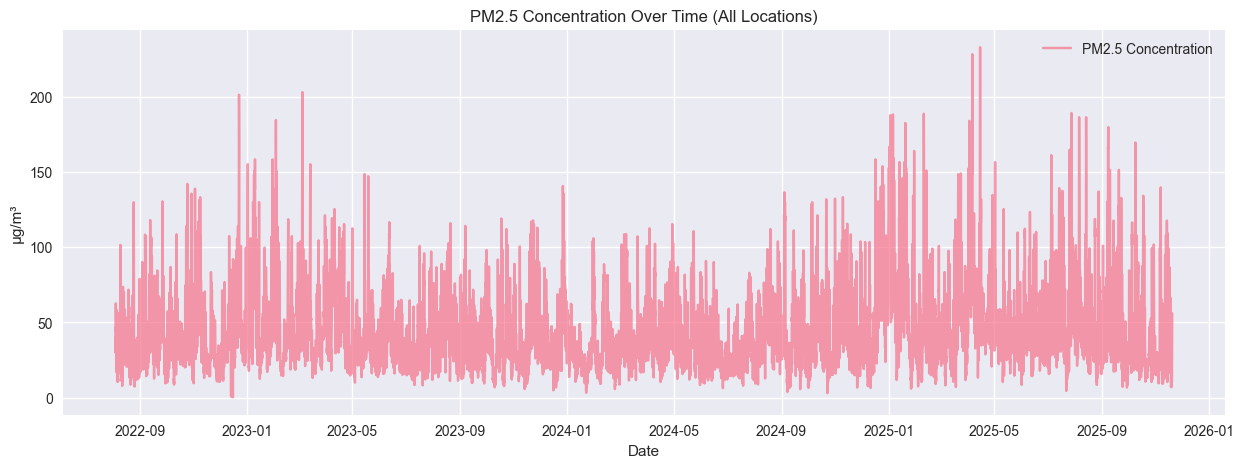

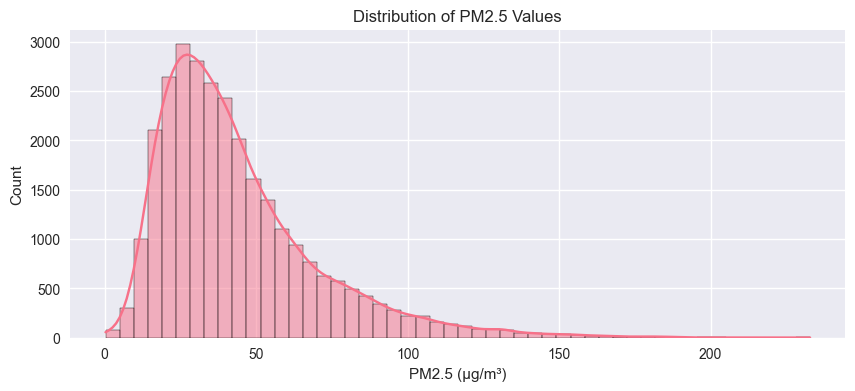

In [3]:
# --- 2. BASIC EDA ---

# Plot the Target Variable (PM2.5)
plt.figure(figsize=(15, 5))
plt.plot(df_model.index, df_model['pm25'], label='PM2.5 Concentration', alpha=0.7)
plt.title('PM2.5 Concentration Over Time (All Locations)')
plt.ylabel('µg/m³')
plt.xlabel('Date')
plt.legend()
plt.show()

# Check Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df_model['pm25'], kde=True, bins=50)
plt.title('Distribution of PM2.5 Values')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()

In [4]:
print(df_model.columns)

Index(['temperature_2m', 'relative_humidity_2m', 'rain', 'wind_direction_10m',
       'wind_speed_10m', 'pm25', 'pm10', 'co', 'no2', 'so2', 'o3', 'aqi',
       'aqi_pm25', 'aqi_category', 'calc_aqi', 'calc_diff', 'hour', 'month',
       'day_of_week', 'is_raining'],
      dtype='object')


In [5]:
# --- 3. FEATURE ENGINEERING ---

def engineer_features_multistep(data):
    """
    Prepares data for multi-step forecasting (t+1 to t+24).
    Row 't' will contain:
      - X: Weather(t), Time(t), PM25(t), PM25(t-1)...
      - y: PM25(t+1), PM25(t+2)... PM25(t+24)
    """
    df_eng = data.copy()
    
    # Location encoding if existed
    if 'lat' in df_eng.columns and 'lon' in df_eng.columns:
        df_eng['loc_id'] = df_eng['lat'].astype(str) + '_' + df_eng['lon'].astype(str)
        loc_dummies = pd.get_dummies(df_eng['loc_id'], prefix='loc')
        loc_dummies = loc_dummies.astype(int)
        df_eng = pd.concat([df_eng, loc_dummies], axis=1)
        loc_features = loc_dummies.columns.tolist()
    else:
        loc_features = []

    # encode month and day_of_week as integers
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    dow_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
        'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }

    df_eng['month'] = df_eng['month'].map(month_map).astype(int)
    df_eng['day_of_week'] = df_eng['day_of_week'].map(dow_map).astype(int)

    # Cyclic time features
    df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng.index.hour / 24)
    df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng.index.hour / 24)
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng.index.month / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng.index.month / 12)
    
    # Wind direction (Handle multiple naming conventions)
    wind_col = None
    for col_name in ['wind_dir', 'wind_direction_10m']:
        if col_name in df_eng.columns:
            wind_col = col_name
            break
            
    if wind_col and 'wind_sin' not in df_eng.columns:
        df_eng['wind_sin'] = np.sin(np.deg2rad(df_eng[wind_col]))
        df_eng['wind_cos'] = np.cos(np.deg2rad(df_eng[wind_col]))

    # Past target value as features
    target_var = 'pm25'
    lags = [1, 2, 3, 6, 12, 24]
    for lag in lags:
        df_eng[f'{target_var}_lag{lag}'] = df_eng[target_var].shift(lag)
        
    # Rolling Stats
    df_eng['pm25_roll_mean_24h'] = df_eng[target_var].shift(1).rolling(window=24).mean()
    
    # TARGETS
    H = 24
    target_cols = []
    for h in range(1, H+1):
        col_name = f'{target_var}_t+{h}'
        df_eng[col_name] = df_eng[target_var].shift(-h)
        target_cols.append(col_name)

    # Cleanup
    df_eng.dropna(inplace=True)
    
    # FEATURE SELECTION
    possible_weather = ['pm25',
        # Dataset 1 styles
        'temp', 'pres', 'wind_spd', 'wind_gust_spd', 'precip', 'humidity', 'no2', 'so2', 'co',
        # Dataset 2 styles
        'temperature_2m', 'relative_humidity_2m', 'is_raining', 'wind_speed_10m'
    ]
    possible_weather += ['wind_sin', 'wind_cos', 'pm25_roll_mean_24h']
    weather_feats = [c for c in possible_weather if c in df_eng.columns]

    # Base Time features for trees
    time_orig_feats = ['hour', 'month', 'day_of_week']
    
    # Derived Time features
    time_eng_feats = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    # Past PM2.5 features
    lag_feats = [f'{target_var}_lag{l}' for l in lags]
    
    # Full Input List
    X_cols = weather_feats + lag_feats + loc_features
    
    return df_eng, X_cols, target_cols, time_orig_feats, time_eng_feats

df_processed, X_cols, target_cols, time_orig_cols, time_eng_cols = engineer_features_multistep(df_model)
X = df_processed[X_cols + time_eng_cols]
y = df_processed[target_cols]
print(f"Data shape before engineering: {df_model.shape}")
print(f"Data shape after engineering: {df_processed.shape}")


Data shape before engineering: (28889, 20)
Data shape after engineering: (28841, 57)


In [6]:
print(X.columns)
print(y.columns)

Index(['pm25', 'no2', 'so2', 'co', 'temperature_2m', 'relative_humidity_2m',
       'is_raining', 'wind_speed_10m', 'wind_sin', 'wind_cos',
       'pm25_roll_mean_24h', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3',
       'pm25_lag6', 'pm25_lag12', 'pm25_lag24', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos'],
      dtype='object')
Index(['pm25_t+1', 'pm25_t+2', 'pm25_t+3', 'pm25_t+4', 'pm25_t+5', 'pm25_t+6',
       'pm25_t+7', 'pm25_t+8', 'pm25_t+9', 'pm25_t+10', 'pm25_t+11',
       'pm25_t+12', 'pm25_t+13', 'pm25_t+14', 'pm25_t+15', 'pm25_t+16',
       'pm25_t+17', 'pm25_t+18', 'pm25_t+19', 'pm25_t+20', 'pm25_t+21',
       'pm25_t+22', 'pm25_t+23', 'pm25_t+24'],
      dtype='object')


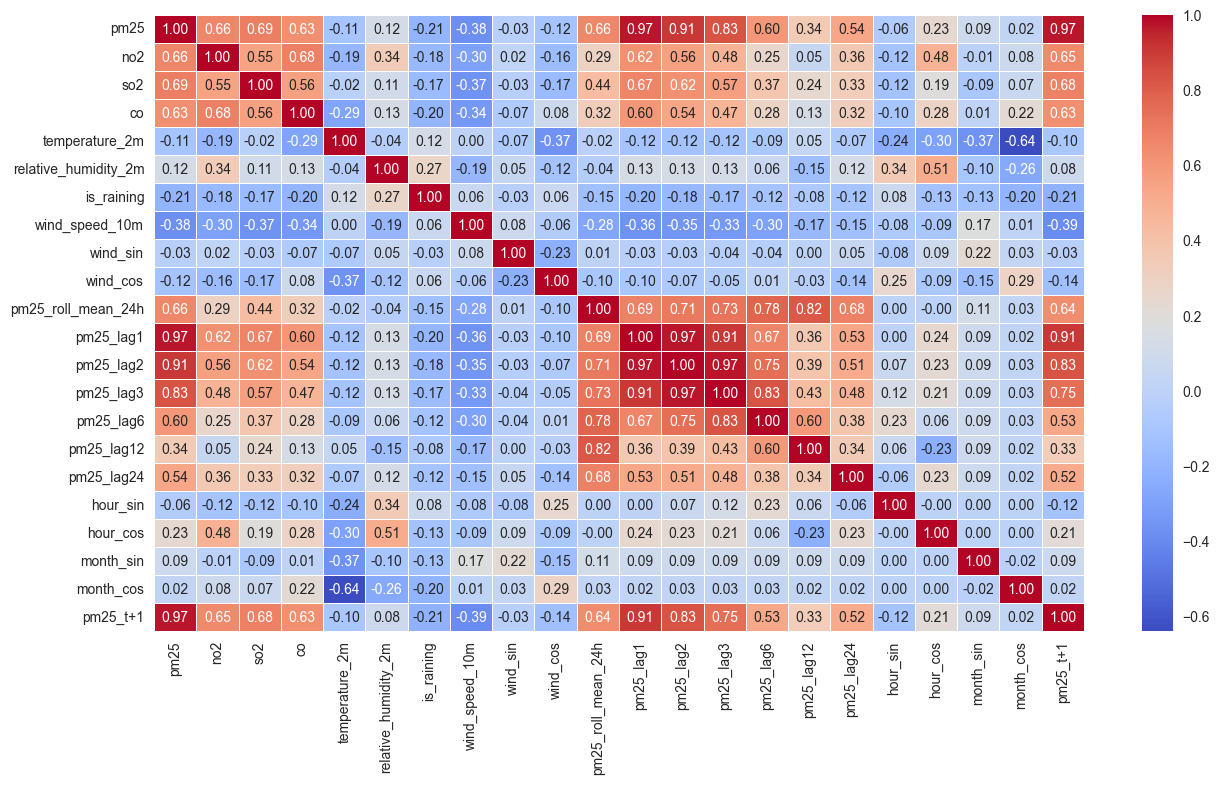

In [7]:
X_with_target = X.copy()

target = 'pm25_t+1'
X_with_target[target] = y[target]

corr_matrix = X_with_target.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

In [8]:
# Feature selection based on correlation threshold
threshold = 0.1

corr_matrix.drop(time_eng_cols, inplace=True)

corr_with_target = corr_matrix.get(target, pd.Series()).abs()
selected_features = corr_with_target[corr_with_target > threshold].sort_values(ascending=False).index.tolist()
selected_features = [f for f in selected_features if f != target]

# Fallback to manual list if nothing selected
if not selected_features:
    selected_features = X_cols

features_str = '\n'.join(selected_features)
print(f"Selected {len(selected_features)} features with |corr| > {threshold}:\n{features_str}")

Selected 14 features with |corr| > 0.1:
pm25
pm25_lag1
pm25_lag2
pm25_lag3
so2
no2
pm25_roll_mean_24h
co
pm25_lag6
pm25_lag24
wind_speed_10m
pm25_lag12
is_raining
wind_cos


In [9]:
# Chronological Split (80/20)
split_idx = int(len(df_processed) * 0.8)
train_df = df_processed.iloc[:split_idx]
test_df = df_processed.iloc[split_idx:]

X_train = train_df[selected_features + time_eng_cols]
y_train = train_df[target_cols]
X_test = test_df[selected_features + time_eng_cols]
y_test = test_df[target_cols]

X_train_tree = train_df[selected_features + time_orig_cols]
X_test_tree = test_df[selected_features + time_orig_cols]

print(f"Train Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")
print(f"Target Shape: {y_train.shape}")
print(f"Test Start Date: {test_df.index.min()}")
print(f"\nInput features: {X_test.columns}")

Train Set Shape: (23072, 18)
Test Set Shape: (5769, 18)
Target Shape: (23072, 24)
Test Start Date: 2025-03-23 15:00:00

Input features: Index(['pm25', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'so2', 'no2',
       'pm25_roll_mean_24h', 'co', 'pm25_lag6', 'pm25_lag24', 'wind_speed_10m',
       'pm25_lag12', 'is_raining', 'wind_cos', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos'],
      dtype='object')


In [10]:
def evaluate_multi_step(name, y_true, y_pred):
    """
    Evaluates multi-step forecasts and prints a formatted table.
    Dynamically handles inputs with fewer than 24 columns (e.g. only t+1).
    
    y_true: numpy array/DataFrame of shape (n_samples, n_horizons)
    y_pred: numpy array/DataFrame of shape (n_samples, n_horizons)
    """
    
    # 1. Convert to Numpy
    if hasattr(y_true, 'values'):
        y_true = y_true.values
    if hasattr(y_pred, 'values'):
        y_pred = y_pred.values
        
    # 2. Handle 1D inputs (Shape N,) -> Reshape to (N, 1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    # 3. Determine available columns based on Prediction input
    # We assume y_true corresponds to y_pred (or has at least as many cols)
    num_cols = y_pred.shape[1]
        
    # Define the horizons we want to report
    horizons = [1, 2, 3, 6, 12, 24]
    
    # Header Formatting
    header = f"{'Metric':<10} |"
    for h in horizons:
        header += f" {'t+'+str(h):<8} |"
    header += f" {'Overall':<8}"
    
    print(f"\n--- {name} Performance ---")
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    # 4. Calculate Per-Step Metrics
    step_results = {}
    
    for h in horizons:
        col_idx = h - 1
        
        # Only calculate if we have data for this horizon
        if col_idx < num_cols:
            # Safely slice both arrays
            # (Assumes y_true has at least as many columns as y_pred)
            if col_idx < y_true.shape[1]:
                true_col = y_true[:, col_idx]
                pred_col = y_pred[:, col_idx]
                
                rmse = np.sqrt(mean_squared_error(true_col, pred_col))
                mae = mean_absolute_error(true_col, pred_col)
                r2 = r2_score(true_col, pred_col)
                
                step_results[h] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            else:
                 # y_pred has col but y_true doesn't (mismatch)
                 step_results[h] = None
        else:
            # Horizon beyond what was predicted
            step_results[h] = None

    # 5. Calculate Overall Metrics (Average across valid columns)
    # We limit y_true to the same number of columns as y_pred for fairness
    if num_cols > 0:
        y_true_sliced = y_true[:, :num_cols]
        y_pred_sliced = y_pred[:, :num_cols]
        
        overall_rmse = np.sqrt(mean_squared_error(y_true_sliced, y_pred_sliced))
        overall_mae = mean_absolute_error(y_true_sliced, y_pred_sliced)
        overall_r2 = r2_score(y_true_sliced, y_pred_sliced)
    else:
        overall_rmse = overall_mae = overall_r2 = None

    # 6. Print Rows
    for metric_name in ['RMSE', 'MAE', 'R2']:
        row_str = f"{metric_name:<10} |"
        
        for h in horizons:
            val = step_results.get(h)
            
            if val is not None:
                # Format actual numbers
                fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
                row_str += f" {val[metric_name]:{fmt}} |"
            else:
                # Format empty cell
                row_str += f" {'-':<8} |"
        
        # Add Overall column
        if overall_rmse is not None:
            val = overall_r2 if metric_name == 'R2' else (overall_rmse if metric_name == 'RMSE' else overall_mae)
            fmt = "<8.3f" if metric_name == 'R2' else "<8.2f"
            row_str += f" {val:{fmt}}"
        else:
            row_str += f" {'-':<8}"
            
        print(row_str)
    print("-" * len(header))

### Baseline: Persistence

In [11]:
# 0. Baseline: Persistence Model (Naive Forecast)
# Prediction for t+n is simply the value at t
y_pred_persist = np.tile(X_test['pm25_lag1'].values.reshape(-1, 1), (1, 24))
evaluate_multi_step('Persistence (Baseline)', y_test, y_pred_persist)


--- Persistence (Baseline) Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 14.02    | 18.91    | 23.02    | 31.87    | 38.65    | 30.16    | 32.74   
MAE        | 9.05     | 12.54    | 15.55    | 22.37    | 28.10    | 20.36    | 22.59   
R2         | 0.779    | 0.598    | 0.404    | -0.141   | -0.677   | -0.027   | -0.207  
---------------------------------------------------------------------------------------


### Linear Regression

In [12]:
# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
evaluate_multi_step('Linear Regression', y_test, y_pred_lr)


--- Linear Regression Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 6.50     | 11.12    | 14.63    | 21.10    | 24.65    | 25.80    | 23.08   
MAE        | 3.90     | 7.23     | 9.85     | 14.47    | 16.80    | 17.16    | 15.23   
R2         | 0.952    | 0.861    | 0.759    | 0.500    | 0.318    | 0.248    | 0.400   
---------------------------------------------------------------------------------------


### XGBoost

In [13]:
# 2.1. XGBoost
print("\n--- Starting Hyperparameter Tuning ---")
print("Go grab a drink as this may take a few minutes...")

# Define the parameter grid
param_dist = {
    'n_estimators': [500, 1000],            # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size
    'max_depth': [3, 5, 7, 9],              # Tree depth (prevent overfitting)
    'subsample': [0.7, 0.8, 0.9],           # % of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9],    # % of features used per tree
    'min_child_weight': [1, 3, 5]           # helps prevent over-fitting on noise
}

# Base model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# TimeSeriesSplit ensures we don't shuffle data during Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_tree, y_train['pm25_t+1'])

best_params = random_search.best_params_
print(f"\nBest Parameters Found: {best_params}")

# Train with best params
best_xgb = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

best_xgb.fit(
    X_train_tree, y_train,
    eval_set=[(X_test_tree, y_test)],
    verbose=False
)


--- Starting Hyperparameter Tuning ---
Go grab a drink as this may take a few minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [14]:
y_pred_xgb = best_xgb.predict(X_test_tree)
evaluate_multi_step('XGBoost', y_test, y_pred_xgb)


--- XGBoost Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 6.95     | 11.02    | 14.12    | 20.41    | 24.48    | 26.17    | 22.85   
MAE        | 4.18     | 7.12     | 9.59     | 14.05    | 16.05    | 17.18    | 14.77   
R2         | 0.946    | 0.863    | 0.776    | 0.532    | 0.327    | 0.226    | 0.412   
---------------------------------------------------------------------------------------


In [15]:
# 2.1.1. XGBoost with engineered time features
print("\n--- Starting Hyperparameter Tuning ---")
print("Go grab a drink as this may take a few minutes...")

# Define the parameter grid
param_dist = {
    'n_estimators': [500, 1000],            # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size
    'max_depth': [3, 5, 7, 9],              # Tree depth (prevent overfitting)
    'subsample': [0.7, 0.8, 0.9],           # % of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9],    # % of features used per tree
    'min_child_weight': [1, 3, 5]           # helps prevent over-fitting on noise
}

# Base model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# TimeSeriesSplit ensures we don't shuffle data during Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train['pm25_t+1'])

best_params = random_search.best_params_
print(f"\nBest Parameters Found: {best_params}")

# Train with best params
best_xgb = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


--- Starting Hyperparameter Tuning ---
Go grab a drink as this may take a few minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters Found: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [16]:
y_pred_xgb = best_xgb.predict(X_test)
evaluate_multi_step('XGBoost', y_test, y_pred_xgb)


--- XGBoost Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 6.70     | 11.03    | 14.05    | 20.41    | 24.47    | 27.00    | 23.22   
MAE        | 3.98     | 7.15     | 9.48     | 13.94    | 16.04    | 17.62    | 14.88   
R2         | 0.949    | 0.863    | 0.778    | 0.532    | 0.328    | 0.177    | 0.393   
---------------------------------------------------------------------------------------


### Random Forest

In [17]:
# 2.2. Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_tree, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",25
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [18]:
y_pred_rf = rf.predict(X_test_tree)
evaluate_multi_step('Random Forest', y_test, y_pred_rf)


--- Random Forest Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 7.97     | 11.92    | 15.08    | 20.96    | 24.53    | 25.71    | 22.99   
MAE        | 5.13     | 7.97     | 10.32    | 14.46    | 16.54    | 17.03    | 15.19   
R2         | 0.928    | 0.840    | 0.744    | 0.506    | 0.325    | 0.253    | 0.405   
---------------------------------------------------------------------------------------


pm25                  0.359558
pm25_lag12            0.076549
hour                  0.070849
wind_cos              0.054718
month                 0.049623
pm25_roll_mean_24h    0.049236
no2                   0.046187
pm25_lag6             0.045358
wind_speed_10m        0.041181
pm25_lag24            0.040565
so2                   0.038519
co                    0.035938
day_of_week           0.028084
pm25_lag3             0.023452
pm25_lag2             0.018112
pm25_lag1             0.017658
is_raining            0.004413
dtype: float64


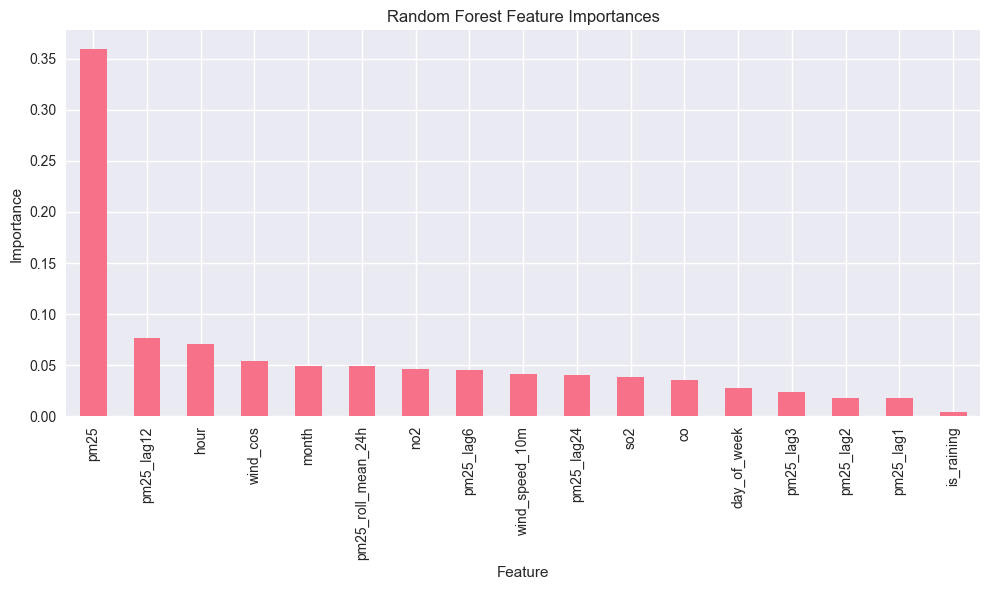

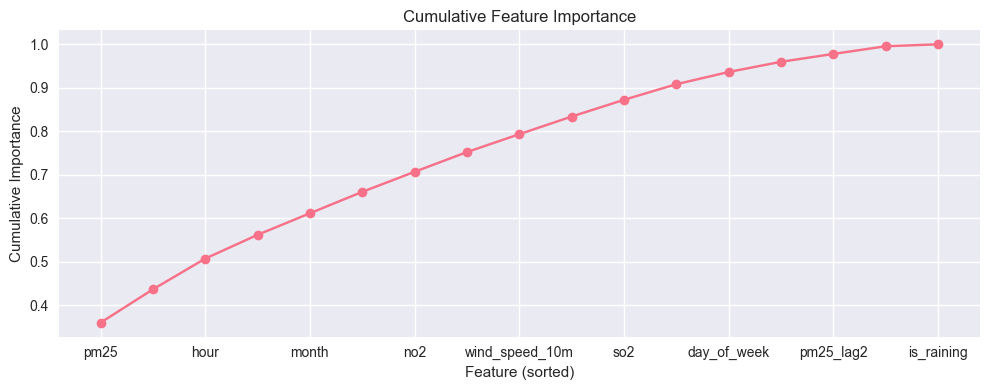

In [19]:
# get feature importances from the trained model
importances = rf.feature_importances_
fi = pd.Series(importances, index=X_train_tree.columns).sort_values(ascending=False)

# display
print(fi)

# bar plot of importances
plt.figure(figsize=(10,6))
fi.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# cumulative importance plot
plt.figure(figsize=(10,4))
fi.cumsum().plot(marker='o')
plt.title("Cumulative Feature Importance")
plt.ylabel("Cumulative Importance")
plt.xlabel("Feature (sorted)")
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMAX

In [20]:
# D. SARIMAX (Level 2.1)
df_ts = df_processed.asfreq('h')
df_ts = df_ts.interpolate(method='time')

print(df_ts.shape)
print(df_ts.columns)

(28841, 57)
Index(['temperature_2m', 'relative_humidity_2m', 'rain', 'wind_direction_10m',
       'wind_speed_10m', 'pm25', 'pm10', 'co', 'no2', 'so2', 'o3', 'aqi',
       'aqi_pm25', 'aqi_category', 'calc_aqi', 'calc_diff', 'hour', 'month',
       'day_of_week', 'is_raining', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'wind_sin', 'wind_cos', 'pm25_lag1', 'pm25_lag2',
       'pm25_lag3', 'pm25_lag6', 'pm25_lag12', 'pm25_lag24',
       'pm25_roll_mean_24h', 'pm25_t+1', 'pm25_t+2', 'pm25_t+3', 'pm25_t+4',
       'pm25_t+5', 'pm25_t+6', 'pm25_t+7', 'pm25_t+8', 'pm25_t+9', 'pm25_t+10',
       'pm25_t+11', 'pm25_t+12', 'pm25_t+13', 'pm25_t+14', 'pm25_t+15',
       'pm25_t+16', 'pm25_t+17', 'pm25_t+18', 'pm25_t+19', 'pm25_t+20',
       'pm25_t+21', 'pm25_t+22', 'pm25_t+23', 'pm25_t+24'],
      dtype='object')


In [21]:
# Perform ADF test
df_pm25 = df_processed[['pm25']].copy()
adf_result = adfuller(df_pm25)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -15.912578733457003
p-value: 8.09197062712724e-29
Critical Values: {'1%': np.float64(-3.430577158150243), '5%': np.float64(-2.861640397607269), '10%': np.float64(-2.566823438609538)}


Generating Diagnostics Plots...


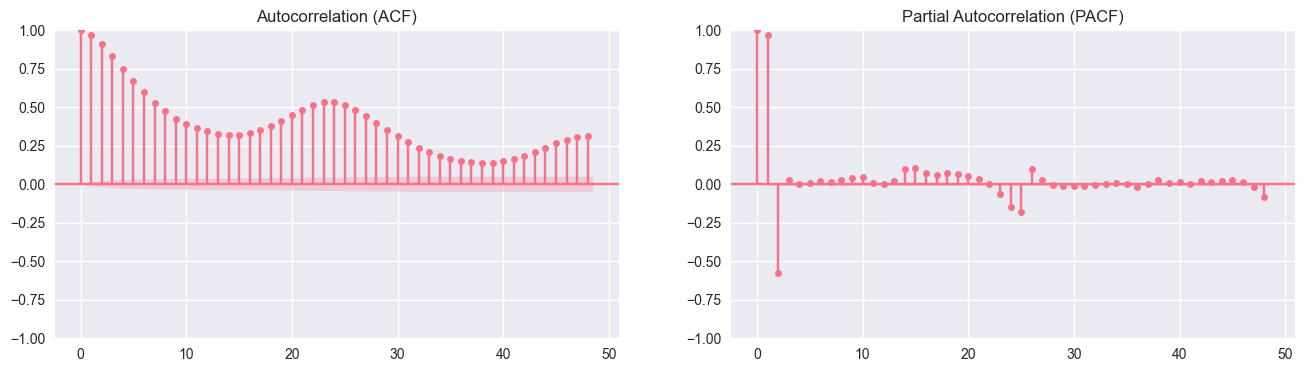

In [22]:
# We analyze the STATIONARITY and Autocorrelation
print("Generating Diagnostics Plots...")

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# Original Series
# Note: PM2.5 is usually stationary-ish, but seasonality might need differencing
plot_acf(df_ts['pm25'].dropna(), lags=48, ax=axes[0], title='Autocorrelation (ACF)')
plot_pacf(df_ts['pm25'].dropna(), lags=48, ax=axes[1], title='Partial Autocorrelation (PACF)')
plt.show()

# Interpretation:
# ACF decaying slowly -> Needs differencing or has strong trend/seasonality
# PACF cuts off after lag k -> Suggests AR(k) model

In [23]:
train_ts = df_ts.iloc[:int(len(df_ts)*0.8)]
test_ts = df_ts.iloc[int(len(df_ts)*0.8):]
print(f'train_ts shape: {train_ts.shape}, test_ts shape: {test_ts.shape}')

exog_cols = selected_features + time_eng_cols
exog_cols.remove('pm25')
print(exog_cols)

train_ts shape: (23072, 57), test_ts shape: (5769, 57)
['pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'so2', 'no2', 'pm25_roll_mean_24h', 'co', 'pm25_lag6', 'pm25_lag24', 'wind_speed_10m', 'pm25_lag12', 'is_raining', 'wind_cos', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [24]:
print("Running Auto-ARIMA search (Stepwise)...")

arimax_model = auto_arima(
    train_ts['pm25'],
    exogenous=train_ts[exog_cols],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    d=None,           
    seasonal=False,   # <--- MEMORY FIX
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

print(arimax_model.summary())
print(f"Best Order: {arimax_model.order}")

Running Auto-ARIMA search (Stepwise)...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                23072
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -68946.711
Date:                Tue, 16 Dec 2025   AIC                         137905.422
Time:                        01:11:58   BIC                         137953.700
Sample:                    08-05-2022   HQIC                        137921.109
                         - 03-23-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5411      0.012    124.138      0.000       1.517       1.565
ar.L2         -0.6166      0.012    -52.681      0.000      -0.640      -0.594
ma.L1       

In [25]:
pred_arima, conf_int = arimax_model.predict(
    n_periods=len(test_ts), 
    exogenous=test_ts[exog_cols],
    return_conf_int=True
)

evaluate_multi_step('ARIMAX', test_ts['pm25_t+1'], pred_arima)


--- ARIMAX Performance ---
---------------------------------------------------------------------------------------
Metric     | t+1      | t+2      | t+3      | t+6      | t+12     | t+24     | Overall 
---------------------------------------------------------------------------------------
RMSE       | 45.69    | -        | -        | -        | -        | -        | 45.69   
MAE        | 41.22    | -        | -        | -        | -        | -        | 41.22   
R2         | -1.350   | -        | -        | -        | -        | -        | -1.350  
---------------------------------------------------------------------------------------


In [26]:
# # E. Facebook Prophet (Level 2.2)

# if PROPHET_AVAILABLE:
#     # Prepare DF
#     df_prophet = df_ts.reset_index()[['time', 'pm25'] + exog_cols].copy()
#     df_prophet.rename(columns={'time': 'ds', 'pm25': 'y'}, inplace=True)
    
#     # Split
#     split_p = int(len(df_prophet)*0.8)
#     train_prophet = df_prophet.iloc[:split_p]
#     test_prophet = df_prophet.iloc[split_p:]
    
#     # Initialize Model
#     # We turn OFF daily_seasonality first, then add it manually with fourier_order
#     # to have more control, or stick to default. Default is usually fine if TZ is fixed.
#     m = Prophet(daily_seasonality=True, weekly_seasonality=True)
    
#     # Add Regressors
#     for col in exog_cols:
#         # 'hour_sin' and 'hour_cos' might be redundant with daily_seasonality=True,
#         # but kept here for consistency with other models.
#         m.add_regressor(col)

#     print("Fitting Prophet...")
#     m.fit(train_prophet)
# else:
#     print("Skipped Prophet.")

In [27]:
# # Predict
# # Prophet needs a future dataframe that includes the dates AND the regressor values
# future = test_prophet.drop(columns=['y'])
# forecast = m.predict(future)

# # Extract prediction
# y_pred_prophet = forecast['yhat'].values
# y_true_prophet = test_prophet['y'].values

# results['Prophet'] = evaluate_model('Prophet', y_true_prophet, y_pred_prophet)

In [28]:
# F. LSTM (Deep Learning - Level 3)